# Flowchart-Detection


In [ ]:
!apt-cache search python3

In [ ]:
!pip freeze

In [ ]:
# 関連ライブラリのインストール
!pip install cairosvg
!apt install tree
!pip install xmltodict
!pip install albumentations
!pip install ultralytics

In [ ]:
!pwd

/content


In [ ]:
!nvidia-smi

In [ ]:
# g-driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/

ckpt	   data_coco_format	       data_from_unimedia  output  tmp_data_xml
damo-yolo  data_coco_format_250129     data_yolo	   runs_l  unimedia_output
data	   data_coco_format_start_end  images		   runs_n


In [ ]:
# datasetへのpathを設定
PATH_TO_FCDetection = '/content/drive/MyDrive/programs/flow-chart-detection'

In [ ]:
!tree /content/drive/MyDrive/programs/flow-chart-detection

# 画像の読み込みと中身確認

In [ ]:
!pip install cairosvg

In [ ]:
# ライブラリのインストール
from PIL import Image
import cairosvg
from io import BytesIO
import cv2
from IPython.display import display
import numpy as np
import os
import glob

In [ ]:
#画像の読み込みと表示
files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data', '*'))
print(f"files: {files}")
for path1 in files:
  if path1.rsplit('.', 1)[1] == 'xml' or path1.rsplit('.', 1)[1] == 'txt':
    continue
  if path1.rsplit('.', 1)[1] == 'svg':
    img = cairosvg.svg2png(url=path1)
    img = Image.open(BytesIO(img))
  else:
    img = Image.open(path1).convert('RGB')
  print("type(img), ", type(img))
  print("img.size, ", img.size)
  # img = cv2.imread(path1)
  display(img)

## アノテーションの読み込み

In [ ]:
files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_from_unicharm', '*'))
print(f"files: {files}")
import xml.etree.ElementTree as ET
for path1 in files:
  if path1.rsplit('.', 1)[1] != 'xml':
    continue
  tree = ET.parse(path1)
  root = tree.getroot()
  for child in root:
    print(child.tag, child.attrib)

## 画像にアノテーションを描画する

In [ ]:
!pip install xmltodict

In [ ]:
from PIL import ImageDraw
import xmltodict
# xmlのみ収集
xml_files = []
files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_from_unicharm', '*'))
for path1 in files:
  if path1.rsplit('.', 1)[1] == 'xml':
    xml_files.append(path1)
print('xml_files', xml_files)

# xmlファイルから対応する画像ファイルを読み込む
for xml_path1 in xml_files:
  # get image path... png, jpg, jpeg, ...etc
  # img_path_base = xml_path1.rsplit('.', 1)[0]
  # files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data', img_path_base + '.*'))
  # img_file_name = None
  # for path1 in files:
  #   if path1.rsplit('.', 1)[1] != 'xml':
  #     img_file_name = path1

  with open(xml_path1, 'r') as f:
      xml_string = f.read()
  xml_dict = xmltodict.parse(xml_string)

  colors = {'terminator':"red",
            'process':"green",
            'decision':"#808080",
            'arrow':"#FFA500",
            'text':"blue",
            'arrow_start':"#800080",
            'data':"grey",
            'connection':"black",
            'arrow_end':"yellow",}

  anno_dict = xml_dict['annotation']
  # open image
  filename = anno_dict['filename']
  file_path = os.path.join(PATH_TO_FCDetection, 'data_from_unicharm', filename)
  print("file_path, ", file_path)
  # if filename.rsplit('.', 1)[1] == 'gif':
  img = Image.open(file_path).convert('RGB')
  # else:
  #   img = Image.open(file_path)
  print("type(img), ", type(img))
  print("img.size, ", img.size)
  # ImageDrawオブジェクトの作成
  draw = ImageDraw.Draw(img)

  for key, value in anno_dict.items():
    if key == 'object':
      for object1 in value:
        print("object1, ", object1)
        xmin = int(object1['bndbox']['xmin'])
        ymin = int(object1['bndbox']['ymin'])
        xmax = int(object1['bndbox']['xmax'])
        ymax = int(object1['bndbox']['ymax'])

        # 矩形の描画
        # (x1, y1)は左上の座標、(x2, y2)は右下の座標
        print("")
        draw.rectangle((xmin, ymin, xmax, ymax), outline=colors[object1['name']],
                       width=3) # fill=colors[object1['name']],

  # 画像の保存
  # img.save('rectangle.png')
  display(img)



# モデルの構築と学習

## importするtorch関係ライブラリ

In [ ]:
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import fcos_resnet50_fpn
from torchvision.models.detection.fcos import FCOSHead
import cv2
import numpy as np
from PIL import Image
import xmltodict
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.4' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## annotationの前処理

In [ ]:
LABELS = {'text':0,
          'arrow':1,
          'connection':2,
          'data':3,
          'decision':4,
          'process':5,
          'terminator':6}


def convert_xml_to_yolo(xml_dir, output_dir, image_dir):
    os.makedirs(output_dir, exist_ok=True)
    xml_files = [f for f in os.listdir(xml_dir) if f.endswith('.xml')]

    for xml_file in xml_files:
        # XMLファイルを読み込み
        tree = ET.parse(os.path.join(xml_dir, xml_file))
        root = tree.getroot()

        # 画像情報を取得
        filename = root.find('filename').text
        img_path = os.path.join(image_dir, filename)
        img_width = int(root.find('size/width').text)
        img_height = int(root.find('size/height').text)

        # 出力先ファイル名
        output_txt_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.txt')

        # バウンディングボックスを変換
        with open(output_txt_path, 'w') as f:
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name not in LABELS:
                    continue  # 定義されていないクラスはスキップ
                class_id = LABELS[class_name]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)

                # YOLO形式に変換
                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                # 書き込み
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

        print(f"Converted {xml_file} to {output_txt_path}")

# パスの設定
# xml_dir = os.path.join(PATH_TO_FCDetection, 'data')  # XMLファイルのディレクトリ
xml_dir = os.path.join(PATH_TO_FCDetection, 'data_from_unimedia')
output_dir = os.path.join(PATH_TO_FCDetection, 'data_yolo')  # YOLO形式アノテーションの出力先
image_dir = os.path.join(PATH_TO_FCDetection, 'data_from_unimedia')  # 画像が格納されているディレクトリ

# 実行
# convert_xml_to_yolo(xml_dir, output_dir, image_dir) # damo-yoloでは実行せず

In [ ]:
!ls drive/MyDrive/programs/flow-chart-detection/damo-yolo/
!pwd

assets	 damo	   demo     NOTICE	  README.md	    scripts   tools
configs  datasets  LICENSE  README_cn.md  requirements.txt  setup.py  workdirs
/content


In [ ]:
# !git clone https://github.com/tinyvision/damo-yolo.git -> 初回のみ
# !ls damo-yolo/
%cd /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo
!pip install -r requirements.txt
import os
os.environ['PYTHONPATH'] = f"{os.getcwd()}:{os.environ.get('PYTHONPATH', '')}"

In [ ]:
!pwd

/content


In [ ]:
import os
%cd /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/
os.environ['PYTHONPATH'] = f"{os.getcwd()}:{os.environ.get('PYTHONPATH', '')}"
!python tools/demo.py --help


/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo
Traceback (most recent call last):
  File "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/tools/demo.py", line 12, in <module>
    from damo.base_models.core.ops import RepConv
  File "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/damo/__init__.py", line 3, in <module>
    from .apis import *
  File "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/damo/apis/__init__.py", line 2, in <module>
    from .detector_trainer import Trainer
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1032, in get_code
  File "<frozen importlib._bootstrap_external>", line 1131, in get_data
KeyboardInterrupt
^C

In [ ]:
!pwd

/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo


In [ ]:
# !pip install cython
import sys
sys.path.append('/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo')
print("sys.path ", sys.path)
# %cd damo-yolo/
!export PYTHONPATH="$PYTHONPATH:/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo"
!echo $PYTHONPATH
# %cd /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo
!ls
# !pip install git+https://github.com/cocodataset/cocoapi.git #subdirectory=PythonAPI # for Linux


sys.path  ['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo']
/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo:/env/python
assets	 damo	   demo     NOTICE	  README.md	    scripts   tools
configs  datasets  LICENSE  README_cn.md  requirements.txt  setup.py  workdirs


In [ ]:
# %cd ../
# !cp -r damo-yolo /content/drive/MyDrive/programs/flow-chart-detection/ -> 初回のみ


/content/damo-yolo


In [ ]:
import sys
!pwd
!ls
import os
os.environ['PYTHONPATH'] = "/env/python:/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo"
!echo $PYTHONPATH

/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo
assets	 damo	   demo     NOTICE	  README.md	    scripts   tools
configs  datasets  LICENSE  README_cn.md  requirements.txt  setup.py  workdirs
/env/python:/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo


In [ ]:
import shutil
import glob
# files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_coco_format/images', '*'))
# print(f"len(files): {len(files)}")
# for file1 in files:

#   shutil.copy(file1, os.path.join(PATH_TO_FCDetection, 'data_coco_format_250129/images/'))
files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_from_unimedia/*'))
for file1 in files:
    shutil.copy(file1, os.path.join(PATH_TO_FCDetection, 'tmp_data_xml/'))
# shutil.copy()

In [ ]:
shutil.copy(os.path.join(PATH_TO_FCDetection, 'data_coco_format/annotations/instances_custom.json'), os.path.join(PATH_TO_FCDetection, 'data_coco_format_250129/annotations/'))

'/content/drive/MyDrive/programs/flow-chart-detection/data_coco_format_250129/annotations/instances_custom.json'

## pascal voc 形式の独自データを coco 形式に変える（初回のみ）

In [ ]:
import os
import json
import xml.etree.ElementTree as ET

# 入力ディレクトリ（XMLファイルと画像が格納されているディレクトリ）
# input_dir = "../tmp_data_xml/"
input_dir = "../data_from_unimedia/"
# output_dir = "../data_coco_format"
output_dir = "../data_coco_format_start_end"
# os.makedirs(os.path.join(output_dir, "annotations"), exist_ok=True)
# os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "annotations"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "images"), exist_ok=True)

# COCO形式のJSONファイル
# output_json_path = os.path.join(output_dir, "annotations", "instances_custom.json")
output_json_path = os.path.join(output_dir, "annotations", "instances_custom.json")

# カテゴリの定義

# categories = [
#     {"id": 1, "name": "text", "supercategory": "object"},
#     {"id": 2, "name": "arrow", "supercategory": "object"},
#     {"id": 3, "name": "terminator", "supercategory": "object"},
#     {"id": 4, "name": "data", "supercategory": "object"},
#     {"id": 5, "name": "process", "supercategory": "object"},
#     {"id": 6, "name": "decision", "supercategory": "object"},
#     {"id": 7, "name": "connection", "supercategory": "object"},
#     # 必要に応じてカテゴリを追加
# ]

categories = [ # arrow_start, arrow_endがあるcase
    {"id": 1, "name": "text", "supercategory": "object"},
    {"id": 2, "name": "arrow", "supercategory": "object"},
    {"id": 3, "name": "terminator", "supercategory": "object"},
    {"id": 4, "name": "data", "supercategory": "object"},
    {"id": 5, "name": "process", "supercategory": "object"},
    {"id": 6, "name": "decision", "supercategory": "object"},
    {"id": 7, "name": "connection", "supercategory": "object"},
    {"id": 8, "name": "arrow_start", "supercategory": "object"},
    {"id": 9, "name": "arrow_end", "supercategory": "object"},
]

category_name_to_id = {category["name"]: category["id"] for category in categories}

# COCO JSONの初期化
coco_format = {
    "images": [],
    "annotations": [],
    "categories": categories,
}

# アノテーションIDカウンタ
annotation_id = 1

# XMLファイルを処理
for xml_file in sorted(os.listdir(input_dir)):
    if not xml_file.endswith(".xml"):
        continue

    # XMLを解析
    tree = ET.parse(os.path.join(input_dir, xml_file))
    root = tree.getroot()

    # 画像情報
    filename = root.find("filename").text
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)
    image_id = len(coco_format["images"]) + 1

    # COCO形式の画像情報を追加
    coco_format["images"].append({
        "id": image_id,
        "file_name": filename,
        "width": width,
        "height": height,
    })

    # 画像を出力フォルダにコピー（オプション）
    image_path = os.path.join(input_dir, filename)
    if os.path.exists(image_path):
        os.system(f"cp {image_path} {os.path.join(output_dir, 'images', filename)}")

    # アノテーション情報を追加
    for obj in root.findall("object"):
        category_name = obj.find("name").text
        if category_name not in category_name_to_id:
            continue  # 定義されていないカテゴリはスキップ

        category_id = category_name_to_id[category_name]
        bbox_xml = obj.find("bndbox")
        xmin = int(bbox_xml.find("xmin").text)
        ymin = int(bbox_xml.find("ymin").text)
        xmax = int(bbox_xml.find("xmax").text)
        ymax = int(bbox_xml.find("ymax").text)

        # COCO形式のbboxは[x, y, width, height]
        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
        area = bbox[2] * bbox[3]  # 面積

        coco_format["annotations"].append({
            "id": annotation_id,
            "image_id": image_id,
            "category_id": category_id,
            "bbox": bbox,
            "area": area,
            "segmentation": [],  # セグメンテーションは省略
            "iscrowd": 0,
        })
        annotation_id += 1

# JSONファイルとして保存
with open(output_json_path, "w") as json_file:
    json.dump(coco_format, json_file, indent=4)

print(f"COCO形式のJSONファイルが生成されました: {output_json_path}")


COCO形式のJSONファイルが生成されました: ../data_coco_format_start_end/annotations/instances_custom.json


In [ ]:
# !ls datasets/custom_coco/images
!ls datasets/custom_coco/annotations/

instances_custom.json


In [ ]:
# datasetをtrainとtestに分離 -> 初回のみ
import os
import shutil
import glob
all_files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_coco_format/images', '*'))
print(f"len(all_files): {len(all_files)}")
all_files.sort()
for num, file1 in enumerate(all_files):
  if num % 10 == 0:
    phase = '_test'
  else:
    phase = '_train'
  shutil.copy(file1, os.path.join(PATH_TO_FCDetection, 'data_coco_format/images' + phase, os.path.basename(file1)))



len(all_files): 122


In [ ]:
# imagesに基づいてannotationsも分離
import os
import shutil
import glob
import json

# all_files = glob.glob(os.path.join(PATH_TO_FCDetection, 'data_coco_format/images', '*'))
# print(f"len(all_files): {len(all_files)}")
# input_json_path = os.path.join(PATH_TO_FCDetection, 'data_coco_format/annotations/instances_custom.json')
# with open(input_json_path, 'r') as f:
#   data = json.load(f)

# instances_custom_train = []
# for data1 in data:
#   if data1['file_name'] in os.listdir(os.path.join(PATH_TO_FCDetection, 'data_coco_format/images_train')):

import json
import os

def split_coco_json(
    input_json_path,
    output_train_json_path,
    output_test_json_path,
    train_image_dir,
    test_image_dir
):
    """COCO JSONファイルを訓練用とテスト用に分割する関数

    Args:
        input_json_path (str): 入力COCO JSONファイルのパス
        output_train_json_path (str): 出力訓練用JSONファイルのパス
        output_test_json_path (str): 出力テスト用JSONファイルのパス
        train_image_dir (str): 訓練用画像ディレクトリのパス
        test_image_dir (str): テスト用画像ディレクトリのパス
    """

    with open(input_json_path, 'r') as f:
        data = json.load(f)

    train_images = {os.path.basename(p) for p in os.listdir(train_image_dir)}
    test_images = {os.path.basename(p) for p in os.listdir(test_image_dir)}

    train_data = {
        "info": data["info"],
        "licenses": data["licenses"],
        "categories": data["categories"],
        "images":[],
        "annotations":[]
    }
    test_data = {
        "info": data["info"],
        "licenses": data["licenses"],
        "categories": data["categories"],
        "images":[],
        "annotations":[]
    }

    for img in data['images']:
        if img['file_name'] in train_images:
            train_data['images'].append(img)
        elif img['file_name'] in test_images:
            test_data['images'].append(img)

    for ann in data['annotations']:
        image_id = ann['image_id']
        for img in train_data['images']:
            if img['id'] == image_id:
                train_data['annotations'].append(ann)
                break
        for img in test_data['images']:
            if img['id'] == image_id:
                test_data['annotations'].append(ann)
                break

    with open(output_train_json_path, 'w') as f:
        json.dump(train_data, f, indent=4)

    with open(output_test_json_path, 'w') as f:
        json.dump(test_data, f, indent=4)


# パスの設定
input_json_path = '/content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/annotations/instances_custom.json'
output_train_json_path = '/content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/annotations_train/instances_custom.json'
output_test_json_path = '/content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/annotations_test/instances_custom.json'
train_image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/images_train'
test_image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/images_test'

# JSONファイルの分割
split_coco_json(
    input_json_path,
    output_train_json_path,
    output_test_json_path,
    train_image_dir,
    test_image_dir
)


KeyError: 'info'

In [ ]:
# data数の取得
!ls -1 /content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/images/ | wc -l
!ls -1 /content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/images_train/ | wc -l
!ls -1 /content/drive/MyDrive/programs/flow-chart-detection/data_coco_format/images_test/ | wc -l
!ls -1 /content/drive/MyDrive/programs/flow-chart-detection/data_coco_format_start_end/images/ | wc -l



122
109
13
79


In [ ]:
!stat /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco

  File: /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco -> /content/drive/MyDrive/programs/data_coco_format_start_end
  Size: 58        	Blocks: 1          IO Block: 65536  symbolic link
Device: 5ah/90d	Inode: 1614        Links: 1
Access: (0600/lrw-------)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2025-02-13 23:37:47.000000000 +0000
Modify: 2025-02-13 23:37:34.000000000 +0000
Change: 2025-02-13 23:37:34.000000000 +0000
 Birth: -


In [ ]:
!ls -l /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/

total 1
lrw------- 1 root root 19 Dec 19 18:10 coco -> /tmp/coco/coco_2017
lrw------- 1 root root  0 Feb 13 23:43 custom_coco -> /content/drive/MyDrive/programs/flow-chart-detection/data_coco_format_start_end


In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/

ls: cannot access '/content/drive/MyDrive/programs/flow-chart-detection/': No such file or directory


In [ ]:
# シンボリックリンクの作成
# !rm /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/
!ln -s /content/drive/MyDrive/programs/flow-chart-detection/data_coco_format_start_end /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco

In [ ]:
!ls -l /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/


total 12
drwx------ 2 root root 4096 Feb 13 23:15 annotations
drwx------ 2 root root 4096 Feb 13 23:15 images
drwx------ 2 root root 4096 Feb 13 23:27 tmp


In [ ]:
# 学習の動作確認
!python tools/train.py -f configs/damoyolo_tinynasL25_S.py -d 1 -b 8 --fp16 -o --cache


## fine-tuneの実行

In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/ckpt # /content/drive/MyDrive/programs/flow-chart-detection/ckpt/damoyolo_tinynasL20_T_436.pth

damoyolo_nano_large.pth   damoyolo_tinynasL20_T_436.pth  fcos_model_60.pth
damoyolo_nano_middle.pth  damoyolo_tinynasL25_S_477.pth  fcos_model.pth
damoyolo_nano_small.pth   fcos_model_30.pth		 fd_model.pth


In [ ]:
!nvidia-smi

Fri Feb 14 01:06:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:

# do fine-tuning
!pwd
# !python tools/train.py -f configs/damoyolo_tinynasL20_T.py -device 0 -batch_size 8 --fp16 -o --cache
!torchrun --nproc_per_node=1 tools/train.py -f configs/damoyolo_tinynasL20_T.py --local_rank 0 --tea_ckpt /content/drive/MyDrive/programs/flow-chart-detection/ckpt/damoyolo_tinynasL20_T_436.pth


Streaming output truncated to the last 5000 lines.
2025-02-14 02:31:37 | INFO     | damo.dataset.datasets.evaluation.coco.coco_eval:59 - OrderedDict([('bbox', OrderedDict([('AP', 0.7783509423502677), ('AP50', 0.9698524221503286), ('AP75', 0.8739044986648308), ('APs', 0.6936984333171173), ('APm', 0.865933253847531), ('APl', 0.8977223652978564)]))])
2025-02-14 02:31:59 | INFO     | damo.apis.detector_trainer:367 - epoch: 1500/3000, iter: 0/3, mem: 8905Mb, iter_time: 0.993s, model_time: 0.634s, total_loss: 0.5, loss_cls: 0.1, loss_bbox: 0.3, loss_dfl: 0.2, lr: 2.612e-03, size: (640, 640), ETA: 1:23:44
2025-02-14 02:31:59 | INFO     | damo.apis.detector_trainer:398 - Save weights to ./workdirs/damoyolo_tinynasL20_T
2025-02-14 02:32:00 | INFO     | damo.apis.detector_inference:75 - Start evaluation on custom_train_coco dataset(79 images).
100%|##########| 1/1 [00:02<00:00,  2.51s/it]
2025-02-14 02:32:02 | INFO     | damo.apis.detector_inference:87 - Total run time: 0:00:02.587748 (0.0327563

In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/

Number of epochs: 1244
Number of AP values: 1244
Number of AR values: 1866


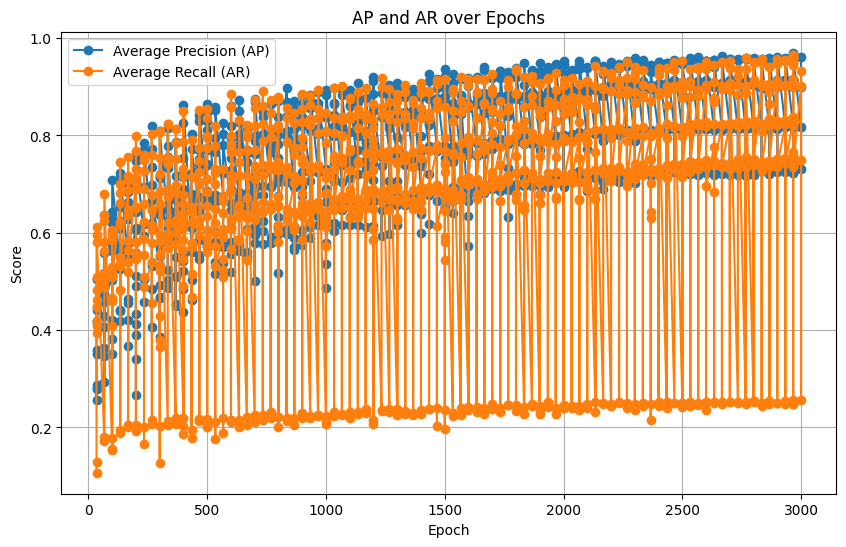

In [ ]:
# 結果の表示
import re
import matplotlib.pyplot as plt

# ファイルを読み込む
# file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2024-12-25-1908'
# file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2024-12-26-1709'
# file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2025-01-30-1442'
# file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2025-02-06-2321'
file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2025-02-14-0107'

with open(file_path, 'r') as file:
    lines = file.readlines()

# APとARの抽出
epochs = []
ap_values = []
ar_values = []
current_epoch = None  # current_epochを初期化

for line in lines:
    # エポック情報を抽出
    epoch_match = re.search(r'epoch: (\d+)/', line)
    if epoch_match:
        current_epoch = int(epoch_match.group(1))

    # current_epochが定義されているかを確認
    if current_epoch is not None:
        # APを抽出
        ap_match = re.search(r'Average Precision\s+\(AP\)\s+@\[\s*IoU=0\.50:0\.95.*=\s+([\d\.]+)', line)
        if ap_match:
            ap_values.append(float(ap_match.group(1)))
            epochs.append(current_epoch)  # APが追加されるときだけエポックを追加

        # ARを抽出
        ar_match = re.search(r'Average Recall\s+\(AR\)\s+@\[\s*IoU=0\.50:0\.95.*=\s+([\d\.]+)', line)
        if ar_match:
            ar_values.append(float(ar_match.group(1)))

# デバッグ用: データの長さを確認
print(f"Number of epochs: {len(epochs)}")
print(f"Number of AP values: {len(ap_values)}")
print(f"Number of AR values: {len(ar_values)}")

# データ数が一致しない場合の調整
min_length = min(len(epochs), len(ap_values), len(ar_values))
epochs = epochs[:min_length]
ap_values = ap_values[:min_length]
ar_values = ar_values[:min_length]

# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(epochs, ap_values, label='Average Precision (AP)', marker='o')
plt.plot(epochs, ar_values, label='Average Recall (AR)', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('AP and AR over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/

2024-12-20-0459      epoch_1840_ckpt.pth	      epoch_2850_ckpt.pth
2024-12-20-0500      epoch_1850_ckpt.pth	      epoch_2860_ckpt.pth
2024-12-20-0501      epoch_1860_ckpt.pth	      epoch_2870_ckpt.pth
2024-12-20-0505      epoch_1870_ckpt.pth	      epoch_2880_ckpt.pth
2024-12-20-0516      epoch_1880_ckpt.pth	      epoch_2890_ckpt.pth
2024-12-24-1319      epoch_1890_ckpt.pth	      epoch_2900_ckpt.pth
2024-12-24-1405      epoch_1900_ckpt.pth	      epoch_290_ckpt.pth
2024-12-25-1847      epoch_190_ckpt.pth		      epoch_2910_ckpt.pth
2024-12-25-1908      epoch_1910_ckpt.pth	      epoch_2920_ckpt.pth
2024-12-26-1709      epoch_1920_ckpt.pth	      epoch_2930_ckpt.pth
2025-01-30-1426      epoch_1930_ckpt.pth	      epoch_2940_ckpt.pth
2025-01-30-1432      epoch_1940_ckpt.pth	      epoch_2950_ckpt.pth
2025-01-30-1437      epoch_1950_ckpt.pth	      epoch_2960_ckpt.pth
2025-01-30-1439      epoch_1960_ckpt.pth	      epoch_2970_ckpt.pth
2025-01-30-1442      epoch_1970_ckpt.pth	      epoch_2980_ckpt.

In [ ]:
!torchrun --nproc_per_node=1 tools/eval.py -f configs/damoyolo_tinynasL20_T.py -c /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/epoch_3000_ckpt.pth --fuse

# !python -m torch.distributed.launch --nproc_per_node=8 tools/eval.py -f configs/damoyolo_tinynasL20_T.py --ckpt /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/epoch_3000_ckpt.pth

In [ ]:
!ls /content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/epoch_3000_ckpt.pth

In [ ]:
# import json
# import cv2
# import matplotlib.pyplot as plt
# import os

# # パスの設定
# image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/images/'
# annotation_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json'

# # アノテーションの読み込み
# with open(annotation_path, 'r') as f:
#     data = json.load(f)

# # 画像情報とアノテーションを取得
# image_info = data["images"][:10]  # 最初の10枚を選択
# annotations = data["annotations"]
# categories = {cat["id"]: cat["name"] for cat in data["categories"]}  # カテゴリ名辞書

# # 画像IDと対応するアノテーションをマッピング
# image_id_to_annotations = {}
# for ann in annotations:
#     image_id = ann["image_id"]
#     if image_id not in image_id_to_annotations:
#         image_id_to_annotations[image_id] = []
#     image_id_to_annotations[image_id].append(ann)

# # 画像の読み込みと描画
# for img_info in image_info:
#     img_path = os.path.join(image_dir, img_info["file_name"])
#     image = cv2.imread(img_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # バウンディングボックスの描画
#     if img_info["id"] in image_id_to_annotations:
#         for ann in image_id_to_annotations[img_info["id"]]:
#             x, y, w, h = ann["bbox"]
#             category_name = categories.get(ann["category_id"], "Unknown")

#             # バウンディングボックスを描画
#             cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)

#             # ラベルを表示
#             cv2.putText(image, category_name, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

#     # 画像を表示
#     plt.figure(figsize=(8, 6))
#     plt.imshow(image)
#     plt.axis("off")
#     plt.title(img_info["file_name"])
#     plt.show()

import json
import cv2
import matplotlib.pyplot as plt
import os

# パスの設定
image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/images/'
annotation_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json'

# アノテーションの読み込み
with open(annotation_path, 'r') as f:
    data = json.load(f)

# 画像情報とアノテーションを取得
image_info = data["images"][:10]  # 最初の10枚を選択
annotations = data["annotations"]
categories = {cat["id"]: cat["name"] for cat in data["categories"]}  # カテゴリ名辞書

# 画像IDと対応するアノテーションをマッピング
image_id_to_annotations = {}
for ann in annotations:
    image_id = ann["image_id"]
    if image_id not in image_id_to_annotations:
        image_id_to_annotations[image_id] = []
    image_id_to_annotations[image_id].append(ann)

# 画像の読み込みと描画
for img_info in image_info:
    img_path = os.path.join(image_dir, img_info["file_name"])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # バウンディングボックスの描画
    if img_info["id"] in image_id_to_annotations:
        for ann in image_id_to_annotations[img_info["id"]]:
            x, y, w, h = ann["bbox"]
            category_name = categories.get(ann["category_id"], "Unknown")

            # クラスによって色を変更
            # if ann["category_id"] in [8, 9]:  # arrow_start と arrow_end
            #     color = (0, 0, 255)  # 青色 (BGR)
            # else:
            #     color = (255, 0, 0)  # 赤色 (BGR)
            if ann["category_id"] == 8:  # arrow_start
                color = (0, 0, 255)  # 青色 (BGR)
            elif ann["category_id"] == 9:  # arrow_end
                color = (0, 255, 0)  # 青色 (BGR)
            else:
                color = (255, 0, 0)  # 赤色 (BGR)

            # バウンディングボックスを描画
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)

            # ラベルを表示
            cv2.putText(image, category_name, (int(x), int(y) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # 画像を表示
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(img_info["file_name"])
    plt.show()



In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# アノテーションファイル (Ground Truth)
gt_json_path = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json"

# 推論結果ファイル (Detection Results)
pred_json_path = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/inference/custom_train_coco/bbox.json"  # 適宜変更

# COCO API を使ってデータを読み込む
coco_gt = COCO(gt_json_path)
coco_dt = coco_gt.loadRes(pred_json_path)

# COCOeval クラスを使って評価
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# クラスごとの AP を算出
category_ids = coco_gt.getCatIds()
category_names = {cat["id"]: cat["name"] for cat in coco_gt.loadCats(category_ids)}

class_wise_ap = {}
for cat_id in category_ids:
    coco_eval.params.catIds = [cat_id]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # AP を保存
    class_wise_ap[category_names[cat_id]] = coco_eval.stats[0]  # AP @[IoU=0.50:0.95]

# クラスごとの AP を表示
for class_name, ap in class_wise_ap.items():
    print(f"Class {class_name}: AP = {ap:.4f}")


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.21s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.76s).
Accumulating evaluation results...
DONE (t=0.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.818
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.971
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.907
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.731
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.961
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.260
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.758
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [ ]:
pred_json_path = "/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/inference/custom_train_coco/bbox.json"

import json
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import defaultdict

# パスの設定
image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/images/'
annotation_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json'
# pred_json_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/output/predictions.json'

# アノテーションの読み込み
with open(annotation_path, 'r') as f:
    data = json.load(f)

# 推論結果の読み込み
with open(pred_json_path, 'r') as f:
    predictions = json.load(f)

# 画像情報とアノテーションを取得
image_info = data["images"]
categories = {cat["id"]: cat["name"] for cat in data["categories"]}
category_ids = list(categories.keys())

# 画像IDと推論結果をマッピング
image_id_to_predictions = defaultdict(list)
for pred in predictions:
    image_id_to_predictions[pred["image_id"]].append(pred)

# 画像の処理
for img_info in image_info[:10]:  # 最初の10枚を処理
    img_path = os.path.join(image_dir, img_info["file_name"])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 推論結果のバウンディングボックスを描画
    if img_info["id"] in image_id_to_predictions:
        for pred in image_id_to_predictions[img_info["id"]]:
            x, y, w, h = pred["bbox"]
            category_id = pred["category_id"]

            # クラスごとの色分け
            if category_id == 8:
                color = (255, 0, 0)  # 赤色 (BGR)
            elif category_id == 9:
                color = (0, 0, 255)  # 青色 (BGR)
            else:
                color = (0, 255, 0)  # 緑色 (BGR)

            # バウンディングボックスを描画（テキストは表示しない）
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)

    # 画像を表示
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(img_info["file_name"])
    plt.show()




In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from collections import defaultdict

# パスの設定
image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/images/'
annotation_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json'

# アノテーションの読み込み
with open(annotation_path, 'r') as f:
    data = json.load(f)

# 画像情報とアノテーションを取得
image_info = data["images"]
annotations = data["annotations"]
categories = {cat["id"]: cat["name"] for cat in data["categories"]}  # カテゴリ名辞書
num_classes = len(categories)

# 画像IDと対応するアノテーションをマッピング
image_id_to_annotations = defaultdict(list)
for ann in annotations:
    image_id_to_annotations[ann["image_id"]].append(ann)

# メトリクス計算用のデータ格納
true_positives = defaultdict(list)
false_positives = defaultdict(list)
num_ground_truths = defaultdict(int)

# 画像の処理
for img_info in image_info:
    img_path = os.path.join(image_dir, img_info["file_name"])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ground_truths = image_id_to_annotations[img_info["id"]]

    # 各カテゴリのGT数をカウント
    for gt in ground_truths:
        num_ground_truths[gt["category_id"]] += 1

    # ダミーの予測 (実際のモデル出力を使用する場合はここに置き換え)
    predictions = []  # 形式: [{'bbox': [x, y, w, h], 'score': 0.9, 'category_id': 1}, ...]

    for pred in predictions:
        best_iou = 0
        matched_gt = None
        for gt in ground_truths:
            if pred["category_id"] == gt["category_id"]:
                # IoUの計算
                x1, y1, w1, h1 = pred["bbox"]
                x2, y2, w2, h2 = gt["bbox"]

                xi1 = max(x1, x2)
                yi1 = max(y1, y2)
                xi2 = min(x1 + w1, x2 + w2)
                yi2 = min(y1 + h1, y2 + h2)

                inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
                box1_area = w1 * h1
                box2_area = w2 * h2
                iou = inter_area / (box1_area + box2_area - inter_area)

                if iou > best_iou:
                    best_iou = iou
                    matched_gt = gt

        if best_iou > 0.5:  # IoU閾値を設定
            true_positives[pred["category_id"]].append(1)
            false_positives[pred["category_id"]].append(0)
        else:
            true_positives[pred["category_id"]].append(0)
            false_positives[pred["category_id"]].append(1)

# APの計算
average_precision = {}
for category_id in range(1, num_classes + 1):
    tp = np.cumsum(true_positives[category_id])
    fp = np.cumsum(false_positives[category_id])
    recall = tp / (num_ground_truths[category_id] + 1e-6)
    precision = tp / (tp + fp + 1e-6)

    # AP計算 (11点補間)
    ap = 0
    for t in np.linspace(0, 1, 11):
        prec_at_t = precision[recall >= t].max() if len(precision[recall >= t]) > 0 else 0
        ap += prec_at_t / 11

    average_precision[category_id] = ap

# 結果を表示
for category_id, ap in average_precision.items():
    print(f"Class {categories[category_id]}: AP = {ap:.4f}")


Class text: AP = 0.0000
Class arrow: AP = 0.0000
Class terminator: AP = 0.0000
Class data: AP = 0.0000
Class process: AP = 0.0000
Class decision: AP = 0.0000
Class connection: AP = 0.0000
Class arrow_start: AP = 0.0000
Class arrow_end: AP = 0.0000


Number of epochs (after adjustment): 89
Image 1: AP length = 89, AR length = 89
Image 2: AP length = 89, AR length = 89
Image 3: AP length = 89, AR length = 89
Image 4: AP length = 89, AR length = 89
Image 5: AP length = 89, AR length = 89
Image 6: AP length = 89, AR length = 89


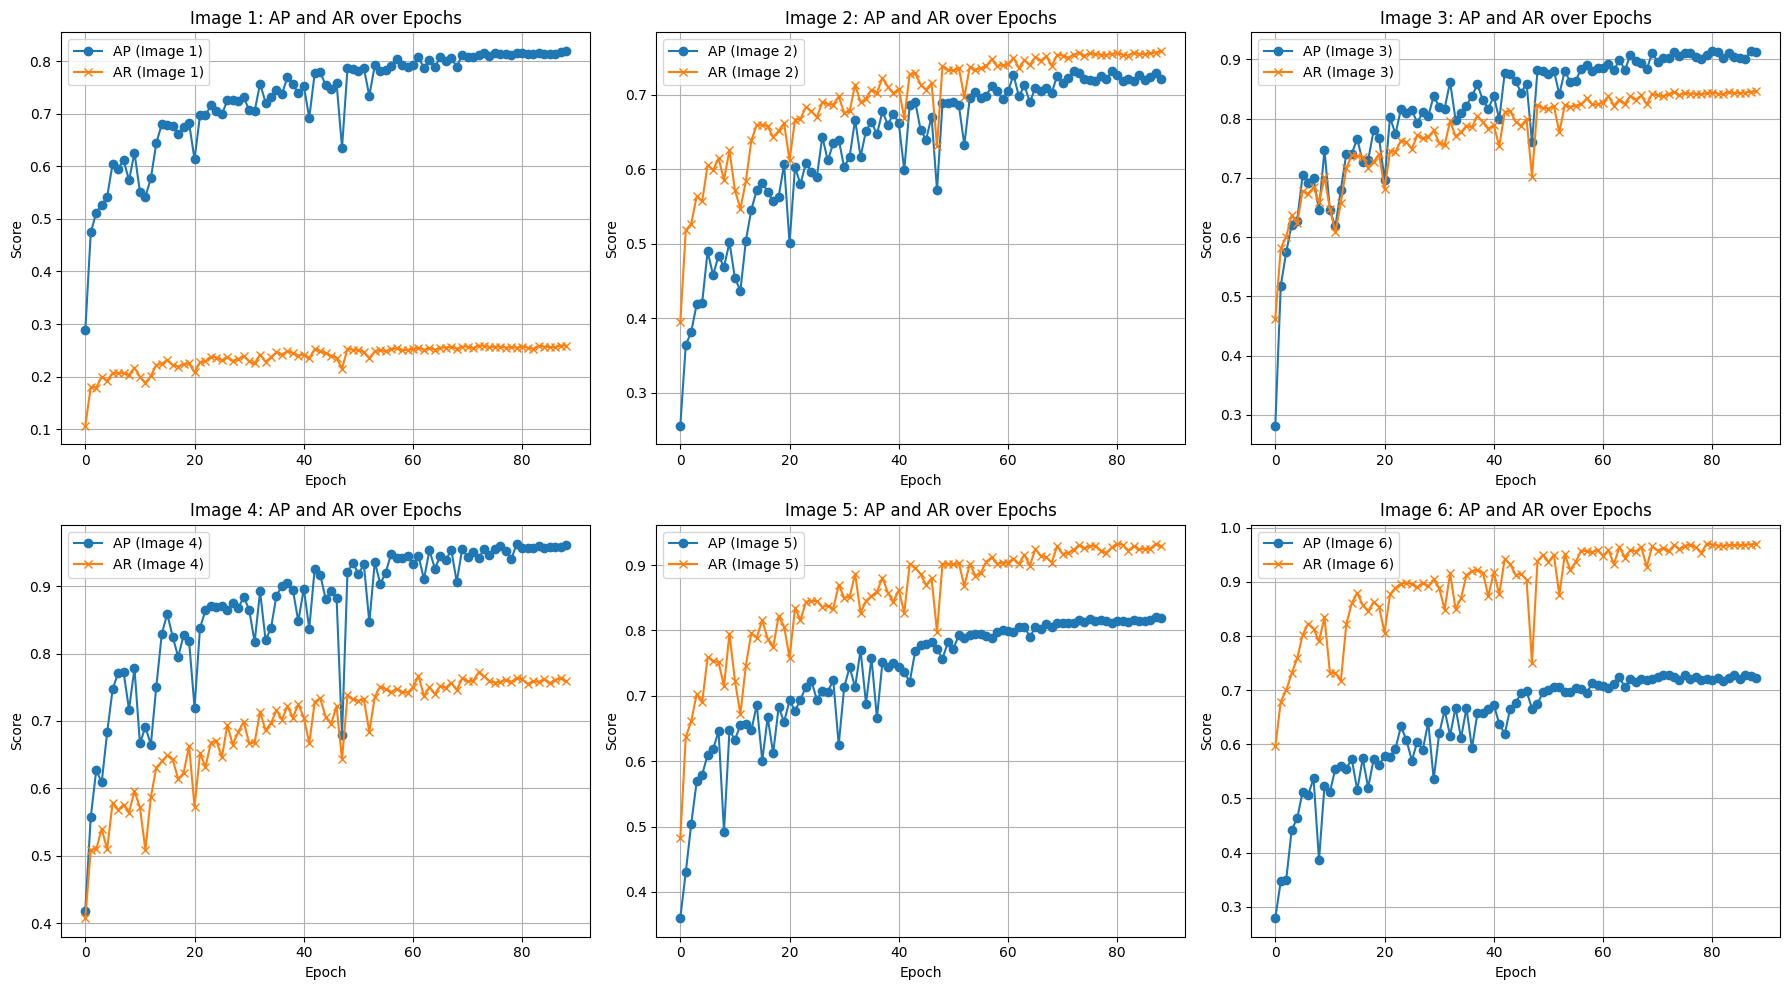

In [ ]:
# '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2024-12-25-1908'

import re
import matplotlib.pyplot as plt

# ファイルを読み込む
# file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2024-12-26-1709'
# file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2025-01-30-1442'
# file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2025-02-06-2321'
file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/2025-02-14-0107'

with open(file_path, 'r') as file:
    lines = file.readlines()

# 各エポックのAPとARデータを格納
ap_per_epoch = []
ar_per_epoch = []
current_epoch = None
current_ap = []  # current_apを初期化
current_ar = []  # current_arを初期化

for line in lines:
    # エポック情報を抽出
    epoch_match = re.search(r'epoch: (\d+)/', line)
    if epoch_match:
        if current_epoch is not None:
            # 現在のエポックが終わったらリストを保存
            ap_per_epoch.append(current_ap)
            ar_per_epoch.append(current_ar)
        current_epoch = int(epoch_match.group(1))
        current_ap = []  # 新しいエポックに備えて初期化
        current_ar = []  # 新しいエポックに備えて初期化

    # APを抽出
    ap_match = re.search(r'Average Precision\s+\(AP\)\s+@\[\s*IoU=0\.50:0\.95.*=\s+([\d\.]+)', line)
    if ap_match:
        current_ap.append(float(ap_match.group(1)))

    # ARを抽出
    ar_match = re.search(r'Average Recall\s+\(AR\)\s+@\[\s*IoU=0\.50:0\.95.*=\s+([\d\.]+)', line)
    if ar_match:
        current_ar.append(float(ar_match.group(1)))

# 最後のエポックデータを追加
if current_epoch is not None:
    ap_per_epoch.append(current_ap)
    ar_per_epoch.append(current_ar)

# 各エポックで6つの画像に対応するデータを抽出
num_epochs = len(ap_per_epoch)
num_images = 6  # 各エポックに6つの画像が含まれると仮定
ap_per_image = [[] for _ in range(num_images)]
ar_per_image = [[] for _ in range(num_images)]

for epoch_idx in range(num_epochs):
    for img_idx in range(min(num_images, len(ap_per_epoch[epoch_idx]))):
        ap_per_image[img_idx].append(ap_per_epoch[epoch_idx][img_idx])
        ar_per_image[img_idx].append(ar_per_epoch[epoch_idx][img_idx])

# データを最短の長さに揃える
min_length = min(len(ap_per_image[i]) for i in range(num_images))
ap_per_image = [ap[:min_length] for ap in ap_per_image]
ar_per_image = [ar[:min_length] for ar in ar_per_image]
epochs = list(range(min_length))  # エポック数も揃える

# デバッグ用: データ確認
print(f"Number of epochs (after adjustment): {min_length}")
for i in range(num_images):
    print(f"Image {i+1}: AP length = {len(ap_per_image[i])}, AR length = {len(ar_per_image[i])}")

# グラフの作成
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2行3列のプロット
axes = axes.flatten()

for i in range(num_images):
    axes[i].plot(epochs, ap_per_image[i], label=f'AP (Image {i+1})', marker='o')
    axes[i].plot(epochs, ar_per_image[i], label=f'AR (Image {i+1})', marker='x')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Score')
    axes[i].set_title(f'Image {i+1}: AP and AR over Epochs')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
!ls //content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/images/


flowchart-example001.webp  flowchart-example020.png   flowchart-example040.png
flowchart-example002.webp  flowchart-example021.png   flowchart-example041.png
flowchart-example003.png   flowchart-example022.jpg   flowchart-example042.png
flowchart-example004.png   flowchart-example025.png   flowchart-example043.png
flowchart-example006.png   flowchart-example027.gif   flowchart-example044.png
flowchart-example007.png   flowchart-example029.webp  flowchart-example045.png
flowchart-example008.jpeg  flowchart-example030.png   flowchart-example046.png
flowchart-example009.jpg   flowchart-example032.png   flowchart-example047.png
flowchart-example012.png   flowchart-example033.png   flowchart-example048.png
flowchart-example013.png   flowchart-example034.png   flowchart-example049.png
flowchart-example014.gif   flowchart-example035.png   flowchart-example050.png
flowchart-example015.png   flowchart-example036.png   flowchart-example051.png
flowchart-example016.png   flowchart-example037.png 

最大AP平均値: 0.8783 (エポック 75)
最大AR平均値: 0.7882 (エポック 76)


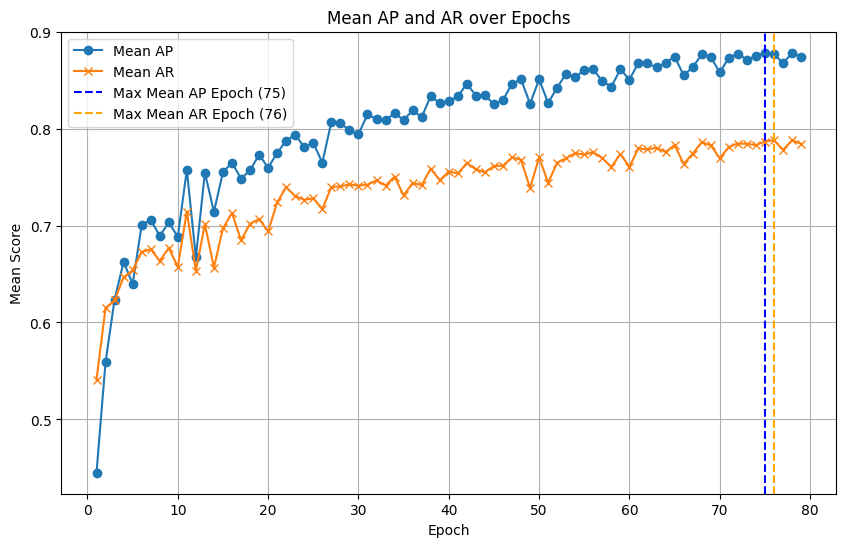

In [ ]:
import numpy as np

# 各エポックにおけるAPとARの平均値を計算
ap_mean_per_epoch = [np.mean([ap_per_image[i][epoch] for i in range(num_images)]) for epoch in range(min_length)]
ar_mean_per_epoch = [np.mean([ar_per_image[i][epoch] for i in range(num_images)]) for epoch in range(min_length)]

# APとARの平均値の最大値を計算
max_ap_mean = max(ap_mean_per_epoch)
max_ar_mean = max(ar_mean_per_epoch)

# 最大値を持つエポックを特定
max_ap_epoch = ap_mean_per_epoch.index(max_ap_mean) + 1  # エポック番号は1から始まると仮定
max_ar_epoch = ar_mean_per_epoch.index(max_ar_mean) + 1

# 結果の表示
print(f"最大AP平均値: {max_ap_mean:.4f} (エポック {max_ap_epoch})")
print(f"最大AR平均値: {max_ar_mean:.4f} (エポック {max_ar_epoch})")

# APとARの平均値をグラフ化
plt.figure(figsize=(10, 6))
plt.plot(range(1, min_length + 1), ap_mean_per_epoch, label='Mean AP', marker='o')
plt.plot(range(1, min_length + 1), ar_mean_per_epoch, label='Mean AR', marker='x')
plt.axvline(max_ap_epoch, color='blue', linestyle='--', label=f'Max Mean AP Epoch ({max_ap_epoch})')
plt.axvline(max_ar_epoch, color='orange', linestyle='--', label=f'Max Mean AR Epoch ({max_ar_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Mean Score')
plt.title('Mean AP and AR over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
import random
import matplotlib.cm as cm

# ファイルの読み込み
file_path = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/workdirs/damoyolo_tinynasL20_T/inference/custom_train_coco/bbox.json'
with open(file_path, 'r') as f:
    data = json.load(f)

# category_idごとの精度を計算
threshold = 0.5  # スコアの閾値
category_counts = defaultdict(int)
category_correct = defaultdict(int)

for entry in data:
    category_id = entry["category_id"]
    score = entry["score"]
    # 閾値を超える場合のみカウント
    category_counts[category_id] += 1
    if score >= threshold:
        category_correct[category_id] += 1

# 精度を計算
category_precision = {
    cat: category_correct[cat] / category_counts[cat] if category_counts[cat] > 0 else 0
    for cat in category_counts
}

# カテゴリごとの色を生成
def get_category_colors(category_ids):
    unique_categories = sorted(set(category_ids))
    colormap = cm.get_cmap('tab10', len(unique_categories))  # カラーマップ
    category_colors = {cat: colormap(i) for i, cat in enumerate(unique_categories)}
    return category_colors

print("Category-wise Precision:")
for cat, precision in category_precision.items():
    print(f"Category {cat}: {precision:.2f}")

# load annotation
image_dir = '/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/images/'
with open('/content/drive/MyDrive/programs/flow-chart-detection/damo-yolo/datasets/custom_coco/annotations/instances_custom.json' , 'r') as f:
  anno = json.load(f)

# Bounding Boxを画像に描画
def draw_bboxes(image_id, file_name, i_w, i_h, data, threshold=0.5, category_colors=None):
    # read image
    image_path = os.path.join(image_dir, file_name)
     # 画像の読み込み
    try:
        image = plt.imread(image_path)
    except (FileNotFoundError, SyntaxError) as e:
        print(f"Error reading image {file_name}: {e}")
        return  # エラー時は描画をスキップ

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image, origin='upper')
    ax.set_xlim(0, i_w)  # 仮の画像サイズ
    ax.set_ylim(i_h, 0)
    # ax.invert_yaxis()  # 画像座標系に合わせる
    ax.set_title(f"Image ID: {image_id} - {file_name}")

    for entry in data:
        if entry["image_id"] == image_id and entry["score"] >= threshold:
            bbox = entry["bbox"]
            category_id = entry["category_id"]
            score = entry["score"]

            # bboxのy座標を反転（画像の高さを基準）
            y = i_h - bbox[1] - bbox[3]

            # カテゴリごとの色を取得
            color = category_colors.get(category_id, 'r')  # 未定義の場合は赤をデフォルト

            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=2, edgecolor=category_colors.get(category_id, 'r'), facecolor='none'
            )
            ax.add_patch(rect)
            # ax.text(
            #     bbox[0], bbox[1] - 10,
            #     f"Cat: {category_id}, Score: {score:.2f}",
            #     color='blue', fontsize=10, bbox=dict(facecolor='white', alpha=0.5)
            # )
    plt.axis('off')
    plt.show()

# 全カテゴリを収集して色を生成
all_categories = [entry["category_id"] for entry in data]
category_colors = get_category_colors(all_categories)

# 任意の画像IDで描画 (例: Image ID = 1)
for data1 in anno['images']:
  image_id = data1['id']
  file_name = data1['file_name']
  width = data1['width']
  height = data1['height']
  print(f"Image ID: {image_id}, File Name: {file_name}, Width: {width}, Height: {height}")
  draw_bboxes(image_id, file_name, width, height, data, threshold=0.5, category_colors=category_colors)
# draw_bboxes(1, data, threshold=0.5)
